This script is for retrieving images based on sketch query 


In [2]:
import numpy as np
from pylab import *
%matplotlib inline
import os
import sys

## caffe

First, we need to import caffe. You'll need to have caffe installed, as well as python interface for caffe. 

In [3]:
#TODO: specify your caffe root folder here
caffe_root = "X:\caffe_siggraph/caffe-windows-master"
sys.path.insert(0, caffe_root+'/python')
import caffe

Now we can load up the network. You can change the path to your own network here. Make sure to use the matching deploy prototxt files and change the target layer to your layer name.

In [4]:
#TODO: change to your own network and deploying file
PRETRAINED_FILE = '../models/triplet_googlenet/triplet_googlenet_finegrain_final.caffemodel' 
sketch_model = '../models/triplet_googlenet/googlenet_sketchdeploy.prototxt'
image_model = '../models/triplet_googlenet/googlenet_imagedeploy.prototxt'

In [ ]:
caffe.set_mode_gpu()
#caffe.set_mode_cpu()
sketch_net = caffe.Net(sketch_model, PRETRAINED_FILE, caffe.TEST)
img_net = caffe.Net(image_model, PRETRAINED_FILE, caffe.TEST)
sketch_net.blobs.keys()

In [6]:
#TODO: set output layer name. You can use sketch_net.blobs.keys() to list all layer
output_layer_sketch = 'pool5/7x7_s1_s'
output_layer_image = 'pool5/7x7_s1_p'

In [7]:
#set the transformer
transformer = caffe.io.Transformer({'data': np.shape(sketch_net.blobs['data'].data)})
transformer.set_mean('data', np.array([104, 117, 123]))
transformer.set_transpose('data',(2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

# Retrieving images

The following script show how to use our network to do the retrieval. The easiest way to use the script is to simply put every images you want to retrieve in one folder and modify 'photo_paths' to point to your folder. Then change 'sketch_path' to point to the sketch you want to use as a query.

## Extracting image feats

In [43]:
#TODO: specify photo folder for the retrieval
photo_paths = 'C:\Users\Patsorn\Documents/notebook_backup/SBIR/retrieval/'

In [44]:
#load up images
img_list = os.listdir(photo_paths)
N = np.shape(img_list)[0]
print 'Retrieving from', N,'photos'

Retrieving from 35 photos


In [45]:
#extract feature for all images
feats = []
for i,path in enumerate(img_list):
    imgname = path.split('/')[-1]
    imgname = imgname.split('.jpg')[0]
    imgcat = path.split('/')[0]
    print '\r',str(i+1)+'/'+str(N)+ ' '+'Extracting ' +path+'...',
    full_path = photo_paths + path
    img = (transformer.preprocess('data', caffe.io.load_image(full_path.rstrip())))
    img_in = np.reshape([img],np.shape(sketch_net.blobs['data'].data))
    out_img = img_net.forward(data=img_in)
    out_img = np.copy(out_img[output_layer_image]) 
    feats.append(out_img)
    print 'done',
np.shape(feats)
feats = np.resize(feats,[np.shape(feats)[0],np.shape(feats)[2]])  #quick fixed for size

35/35 Extracting flickr_8475629670.jpg... done


In [46]:
#build nn pool
from sklearn.neighbors import NearestNeighbors,LSHForest
nbrs  = NearestNeighbors(n_neighbors=np.size(feats,0), algorithm='brute',metric='cosine').fit(feats)

# Show top 5 retrieval results

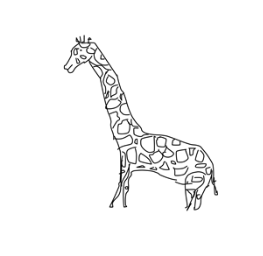

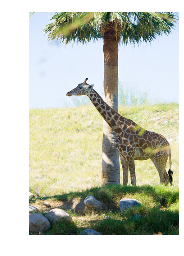

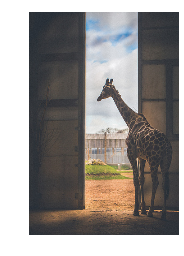

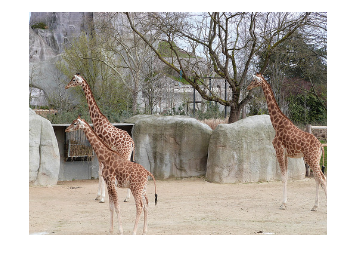

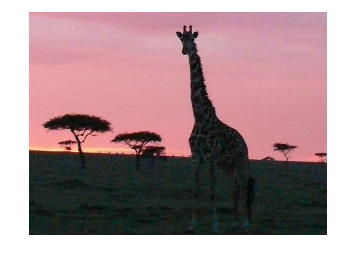

In [47]:

#Load up sketch query 
sketch_path = "X:\data_for_research\sketch_dataset\png/giraffe/7366.png"
sketch_in = (transformer.preprocess('data', caffe.io.load_image(sketch_path)))
sketch_in = np.reshape([sketch_in],np.shape(sketch_net.blobs['data'].data))
query = sketch_net.forward(data=sketch_in)
query=np.copy(query[output_layer_sketch])

#get nn
distances, indices = nbrs.kneighbors(np.reshape(query,[np.shape(query)[1]]))

#show query
f = plt.figure(0)
plt.imshow(plt.imread(sketch_path))
plt.axis('off')

#show results
for i in range(1,5,1):
    f = plt.figure(i)
    img = plt.imread(photo_paths+img_list[indices[0][i-1]])
    plt.imshow(img)
    plt.axis('off')
    plt.show(block=False)